Load Packages

In [1]:
library(tsModel); library(splines); library(data.table); library(lmtest); library(mgcv); library(readxl); library(ggplot2); library(MuMIn); library(dplyr);

Time Series Modeling for Air Pollution and Health (0.6-2)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:data.table':

    yearmon, yearqtr


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Load city's dataset and perform some preprocessing

In [2]:
# Load and inspect the dataset.
data <- read.csv("Irbid.csv")
# convert data into Rdata table
data <- as.data.table(data)
data$date <- as.Date(data$Date)
data$trend <- as.numeric(data$date)
data$year <- year(data$date)
data$dow <- weekdays(data$date)
data$temp <- data$t2m
# Number of years
nyears=length(unique(data$year))

# Sort data by date
data <- data[order(data$date),]

names(data)
head(data)

[1] "Date"             "Total..30"        "Total_Male..30"   "Total_Female..30"
 [5] "X.65"             "X.65_Male"        "X.65_Female"      "Premature"       
 [9] "Premature_Male"   "Premature_Female" "YLL"              "YLL_Male"        
[13] "YLL_Female"       "Total"            "Total_Male"       "Total_Female"    
[17] "Holiday"          "PM10"             "NO2"              "SO2"             
[21] "t2m"              "sp"               "d2m"              "RH"              
[25] "Holiday.1"        "date"             "trend"            "year"            
[29] "dow"              "temp"

Date,Total..30,Total_Male..30,Total_Female..30,X.65,X.65_Male,X.65_Female,Premature,Premature_Male,Premature_Female,⋯,t2m,sp,d2m,RH,Holiday.1,date,trend,year,dow,temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<date>,<dbl>,<int>,<chr>,<dbl>
2015-01-01,4,2,2,3,1,2,3,1,2,⋯,12.49,96.4432,5.67,63.15,1,2015-01-01,16436,2015,Thursday,12.49
2015-01-02,4,4,0,4,4,0,2,2,0,⋯,10.42,96.7323,6.52,76.79,0,2015-01-02,16437,2015,Friday,10.42
2015-01-03,7,4,3,5,3,2,5,4,1,⋯,9.41,96.4831,6.76,83.53,1,2015-01-03,16438,2015,Saturday,9.41
2015-01-04,5,1,4,4,1,3,4,0,4,⋯,9.45,96.3790,6.80,83.53,0,2015-01-04,16439,2015,Sunday,9.45
2015-01-05,1,1,0,1,1,0,1,1,0,⋯,10.95,96.0709,4.64,65.07,0,2015-01-05,16440,2015,Monday,10.95
2015-01-06,2,0,2,2,0,2,2,0,2,⋯,10.10,95.7186,1.57,55.43,0,2015-01-06,16441,2015,Tuesday,10.10


Specify the target variable (y)

In [3]:
data$y <- data$Total..30
data$y

[1]  4  4  7  5  1  2  7  4  3  7  5  2 10 13  5 11  5  9  1  4  4  7  3  1
  [25]  4  2  3  4  5  4  4  5  4  2  8  6  5  2  3  5  1  2  2  6  5  3  5  6
  [49]  4  5  3  9  1  3  3  3 NA  3  2  2  5  3  4  6  9  2  3  8  5  4  1  6
  [73]  6  6  2  7  6  2  9  3 10  3  8  1  1  2  6  2  6  4  4  4  3  3  5  3
  [97]  4  3  2  3  4  3  3  4  4  7  6  4  4  6  4  3  5  1  3  1  2  5  5  5
 [121]  3  0  2  3  2  5  5  2  1  3 11  3  4  3  1  6  5  3  7  4  3  4  2  2
 [145]  3  5  6  5  4  4  6  3  6  0  5  5  6  1  4  1  3  3  3  2  4  4  2  4
 [169]  1  4  2  3  2  1  1  6  4  3  3  4  2  5  5 NA 10  5  0  5  2  4  5  3
 [193]  5  4  2  5  0  5  6  2  3  2  4  2  2  6  4  3  3 NA  8  6  2  3  7  5
 [217]  3  8  4  4  6  2  4  5  2  3  2  3  6  5  1  4  4  2  3  7  7  4  4 NA
 [241] NA  3  7  3  5  4  3  3  2  2  5  5  3  3  4  4  4  7  3  3  5  3  3  2
 [265]  1  6  2  7  1  6  3  2  2  7  2  5  2  3  4  3  2  5  3  6  1  5  3  5
 [289]  3  2  2  7  3  2  3  3  5  3  5  2  4  3  4  3  1  5  0  5 11  1  2  5
 [313]  4  4  3  4  3  5  9  5  4  3  4  7  6  3  4  4  4  6  9  2  5  9  3  8
 [337]  4  5  3  4  2  5  6  7  4  2  1  6  2  5  3  7  2  4  5  4  4  8  5  3
 [361]  3  3  2  5  6  6  3  7  2  4  6  1  4  5  4  6  3  8  4  9  5  1  6  1
 [385]  3  4  5  1  8  7  4  5  6  4  7  4  6  5  5  4  6  1  2  3  4  4  5  8
 [409]  4  4  8  4  3  6  8  3  5  5  5  6  4  2  5  8  2 11  2  4  5  6  0  5
 [433]  6  6  7  3  3  1  2  2  5  5  2  6  3  7  1  4  6  8  3  1  3  4  6  2
 [457]  5  3  5  6  2  5  5  1  7  3  5  3  6  8  1  1  5  6  5  9  4  6  1  4
 [481]  2  4  3  3  2  2  3  7  5  3  3  1  3  1  2  5 NA  4  4  2  3 11  3  6
 [505]  3  3  5  5  3  6  2 NA  2  2  3  5  1  3  3  1  2  4  3  2  6  1  3  4
 [529]  5  4  3  3  3  2  4  1  6  1  3  6  1  6  6  3  2  2  3  1  3  6  1  1
 [553]  8  5  3  4  3  4  4  1  5  7  4  4  2  4  3  5  3  2  3  2 NA  3  6  1
 [577]  0  2  7  4  2  6  1  7  2  5  3  2  3  3 NA  9  2  3  2  3  2  1  4  3
 [601]  3  2  3  2  1  4  5  3  1  2  2  1  1  7  1  4  2  2  4  4  6  1  3  3
 [625]  1  2 NA  4  2  2  5  1  4  4  3  3  1  2  3  3  5  6  7  6  2  5  3  2
 [649]  5  1  1  3  3  3  4  1  4 NA  2  6  3  6  3  2  3  1  3  3  3  3  4  1
 [673]  4  6  4  1 NA  4  2  3  1  5  3  5  3  4  4  4  2  2  2  4  6  5  8  7
 [697]  6  9  4  3  5  6  2  4  4  6  4  8  4  4  4  1  7  5  8  2  5  0 10  5
 [721] 10  6  4  4  2  4  6  3  3  3  8  2  7  5  3  7  7  6  5  6  6  6 10  2
 [745]  5 11 12  1  2  5  5  6  3  4  0  5  9  4  3  8  8  3  7  2  7  2  9  5
 [769]  2  6  7  4  2  4  2  9  5  6  5  2  7  7  3  4  1  4  6  7  5  1  8  5
 [793]  3  7  3  3  6  6  2  4  5  6  3  3  1  2  4  5  4  1  3  3  4  5  6  6
 [817]  2  2  5  2  5  7  5  4  6  5  5  5  4  6  2  9  5  5  4  2  2  6  1  2
 [841]  3  3  5  4  2  6  2  9  5  7  3  7  3  4  4  4  1  6  4  4  8  5  3  1
 [865]  5  9  0  4  2  4  1  4  2  3  3  1  6  2  5 NA  5  7  5  3  9  3  4  3
 [889]  6  5  5  3  3  2  2  6  1  3  3  4  5  2  0  5  3  3  3  2  2  5  4  4
 [913]  4  1  4  7  3  5  7  5  1  4  4  4  2  5  5  4  4  4  3 NA  5  4  5  3
 [937]  5  7  3  1  6  3  3  2  4 NA  9  1  2  6  1  2  4  3  5  5  4  2  3  5
 [961]  3  2  4  1  1  6  3  4  8  4  4  2  2  4  3  5  6  4  5  3  2  1  4  5
 [985]  2  1  4  1 NA  4  2  2  6  3  1  0  8  4  5  1  3  3  3  1  4  2  5  4
[1009]  4  3  3  6  4  3  7  1  3  3  5  3  7  3  2  4  8  4  5  8  4  4  4  3
[1033]  4  8  2  3  3  3  4 NA  6  6  5  5  5  3  2  3  4  6  5  7  1  6  7  7
[1057]  6  6  4  2  2  2  2  5  5  3  3  4  3  2  2  3  6  7  8  5  8  7  9  6
[1081]  4  5  4  5  5  7  5  5  4  6  7  3  7  8  3  7  7  1  4  3  9  1  4  5
[1105]  2  1  4  9  5  1  5  4  3  2  2  4  6  4  4  3 10  6  4  4  5  5  4  3
[1129]  1  4  5  3  2  6  5  3  3  5  1  6  2  5  2  3  5  5  5  9  4  6  4  2
[1153]  2  7  4 11  3  2  5  1  3  4  5  2  1  3  5  6  9 NA  4  6  3  5  3  2
[1177]  3  9  5  3  3  3  1  6  2  5  4  3  4  4  4  2  6  4  5  5  5  3  4  3
[1201]  4  3  6 NA  3  7  5  4  2  5  2  4  3  5  4  

Time series plotting

Visualize target variable overtime

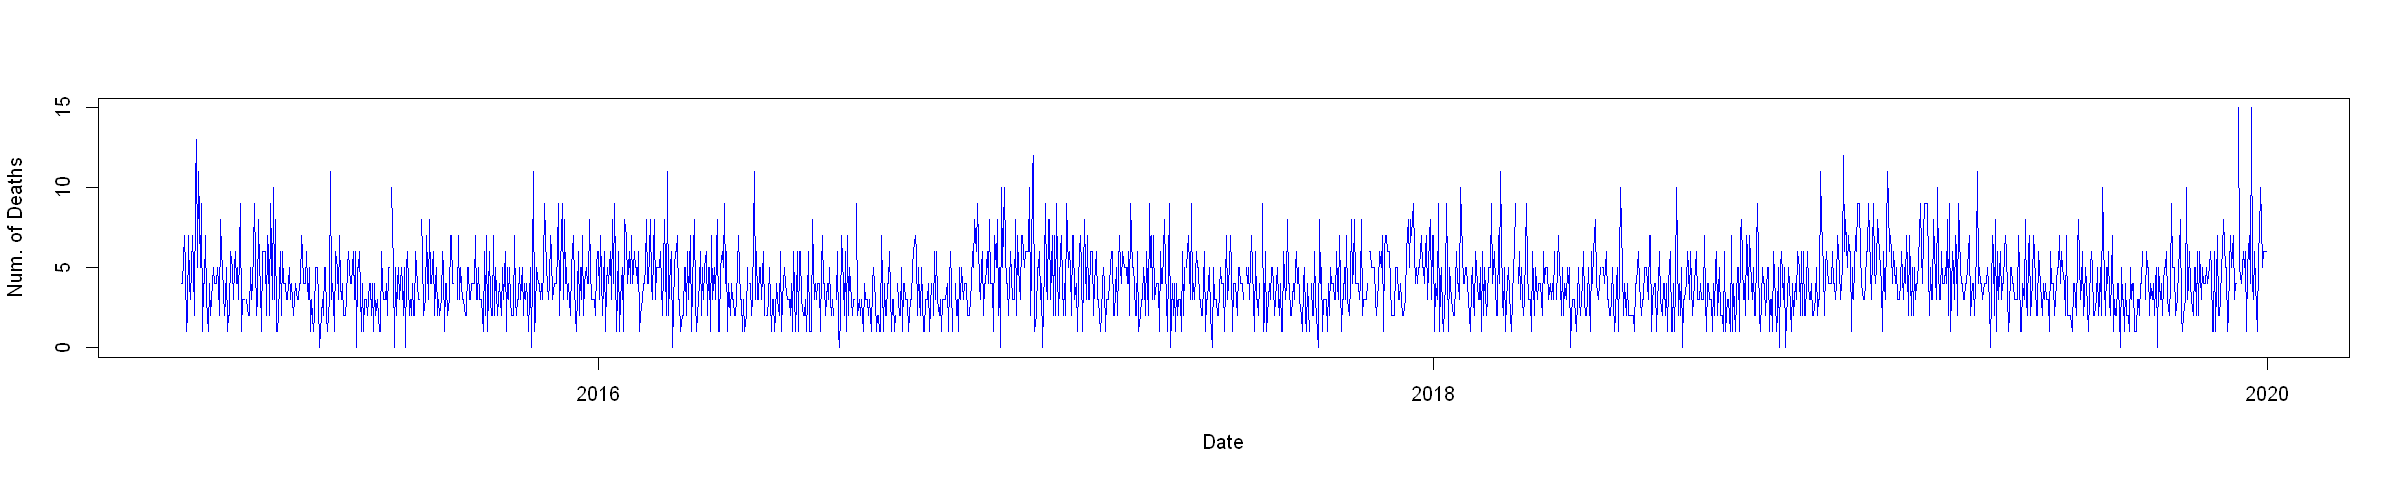

In [4]:
options(repr.plot.width=20, repr.plot.height=4)
plot(data$date, data$y, type="l", col= "blue", ylab="Num. of Deaths", xlab="Date")

Now we want to define the model as follows:
- Two spline terms for temperature, hot and cold
- Spline for trend to detrend the data and control for long-term trend and seasonality
- Day of week as a factor
- Holiday as a factor

define the required terms for temperature

In [5]:
data$l01temp 	<- (data$temp + lag(data$temp,1))/2
data$l16temp 	<- (lag(data$temp,1)+lag(data$temp,2)+lag(data$temp,3)+lag(data$temp,4)+lag(data$temp,5)+lag(data$temp,6))/6
data$l01temphot  <- ((data$l01temp - median(data$l01temp,na.rm=T))*(data$l01temp >= median(data$l01temp,na.rm=T)))+median(data$l01temp,na.rm=T)
data$l16tempcold <- ((data$l16temp - median(data$l16temp,na.rm=T))*(data$l16temp <= median(data$l16temp,na.rm=T)))+median(data$l16temp,na.rm=T)

perc.hot		    <- c(75/100, 90/100)
perc.cold		    <- c(25/100)
ktemphot.lag01	<- as.vector(quantile(data$l01temphot, perc.hot, na.rm=T))
ktempcold.lag16	<- as.vector(quantile(data$l16tempcold,perc.cold,na.rm=T))

Now perform sensitivity analysis to specify the optimal degrees of freedom per year for trend spline term

In [6]:
# Custom QAIC function for quasi-Poisson
QAIC <- function(model) {
  if (family(model)$family != "quasipoisson") {
    stop("Model must be quasi-Poisson")
  }
  
  # Overdispersion parameter (phi)
  phi <- summary(model)$dispersion
  
  # Refit as Poisson to get logLik
  mod_pois <- update(model, family = poisson)
  ll <- as.numeric(logLik(mod_pois))
  
  # Number of estimated parameters
  k <- length(coef(model))
  
  # QAIC formula
  qaic <- -2 * ll / phi + 2 * k
  return(qaic)
}

results <- data.frame(df_trend = integer(),
                      coef_PM = numeric(),
                      se_PM   = numeric(),
                      perc_increase = numeric(),
                      lowerCI = numeric(),
                      upperCI = numeric(),
                      qaic = numeric(),
                      lb_pvalue = numeric(),
                      Pr_val = numeric(),
                      stringsAsFactors = FALSE)

# Number of years in your dataset
nyears <- length(unique(format(data$date, "%Y")))

# Range of df multipliers you want to test for trend
df_range <- 4:8   # e.g. 4–10 per year, adjust as needed

results <- data.frame(df_time = integer(),
                      qaic = numeric(),
                      stringsAsFactors = FALSE)

for (df in df_range) {
  mod <- glm(y ~ PM10 + ns(l01temphot, k = ktemphot.lag01) +
                   ns(l16tempcold, k = ktempcold.lag16) +
                   ns(trend, df = df * nyears) +
                   as.factor(dow) +
                   as.factor(Holiday.1),
             data = data, family = quasipoisson)
  
  coef_PM <- coef(mod)["PM10"]
  se_PM   <- sqrt(vcov(mod)["PM10", "PM10"])
  
  # % change in mortality per unit increase (adjust as needed, e.g. per 10 units)
  perc_increase <- (exp(coef_PM * 10) - 1) * 100
  lowerCI <- (exp((coef_PM - 1.96*se_PM) * 10) - 1) * 100
  upperCI <- (exp((coef_PM + 1.96*se_PM) * 10) - 1) * 100

  qaic_val <- QAIC(mod)
  lb <- Box.test(residuals(mod, type="pearson"), lag = 20, type = "Ljung-Box")
  
  results <- rbind(results,
                   data.frame(df_trend = df,
                              coef_PM = coef_PM,
                              se_PM = se_PM,
                              perc_increase = perc_increase,
                              lowerCI = lowerCI,
                              upperCI = upperCI,
                              qaic = qaic_val,
                              lb_pvalue = lb$p.value,
                              Pr_val = summary(mod)$coefficients[2, "Pr(>|t|)"]))
}

print(results)



      df_trend       coef_PM        se_PM perc_increase   lowerCI   upperCI
PM10         4  3.340515e-06 0.0005378820   0.003340570 -1.045406 1.0632015
PM101        5 -6.495733e-06 0.0005412505  -0.006495522 -1.061671 1.0599332
PM102        6 -8.731543e-05 0.0005457773  -0.087277318 -1.150371 0.9872495
PM103        7 -2.558724e-04 0.0005504789  -0.255545353 -1.325942 0.8264628
PM104        8 -2.396493e-04 0.0005482513  -0.239362385 -1.305624 0.8384185
          qaic   lb_pvalue    Pr_val
PM10  7355.997 0.122493871 0.9950455
PM101 7366.433 0.063477373 0.9904259
PM102 7371.727 0.033575253 0.8729128
PM103 7396.563 0.008286960 0.6421210
PM104 7399.750 0.002969303 0.6620827


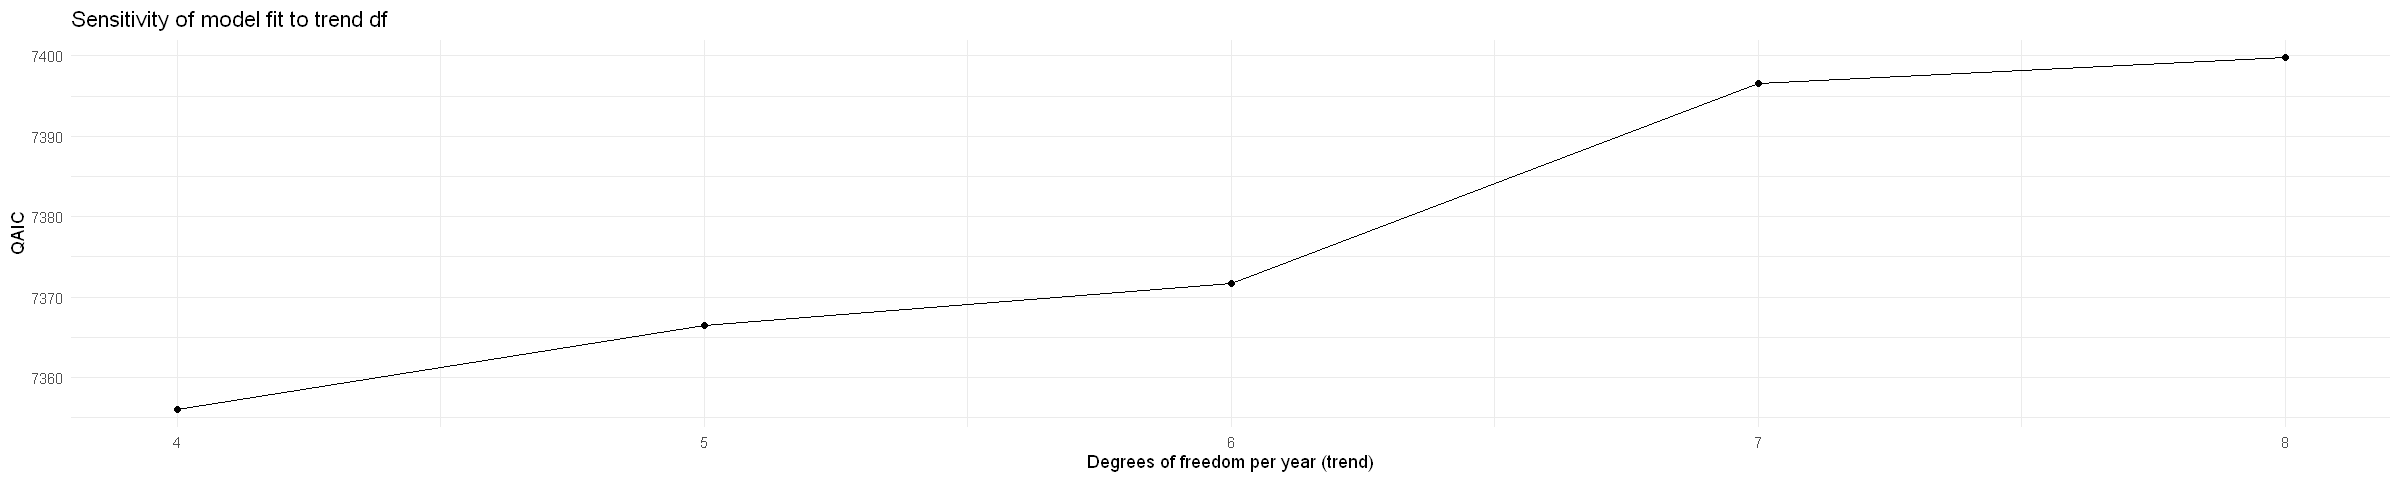

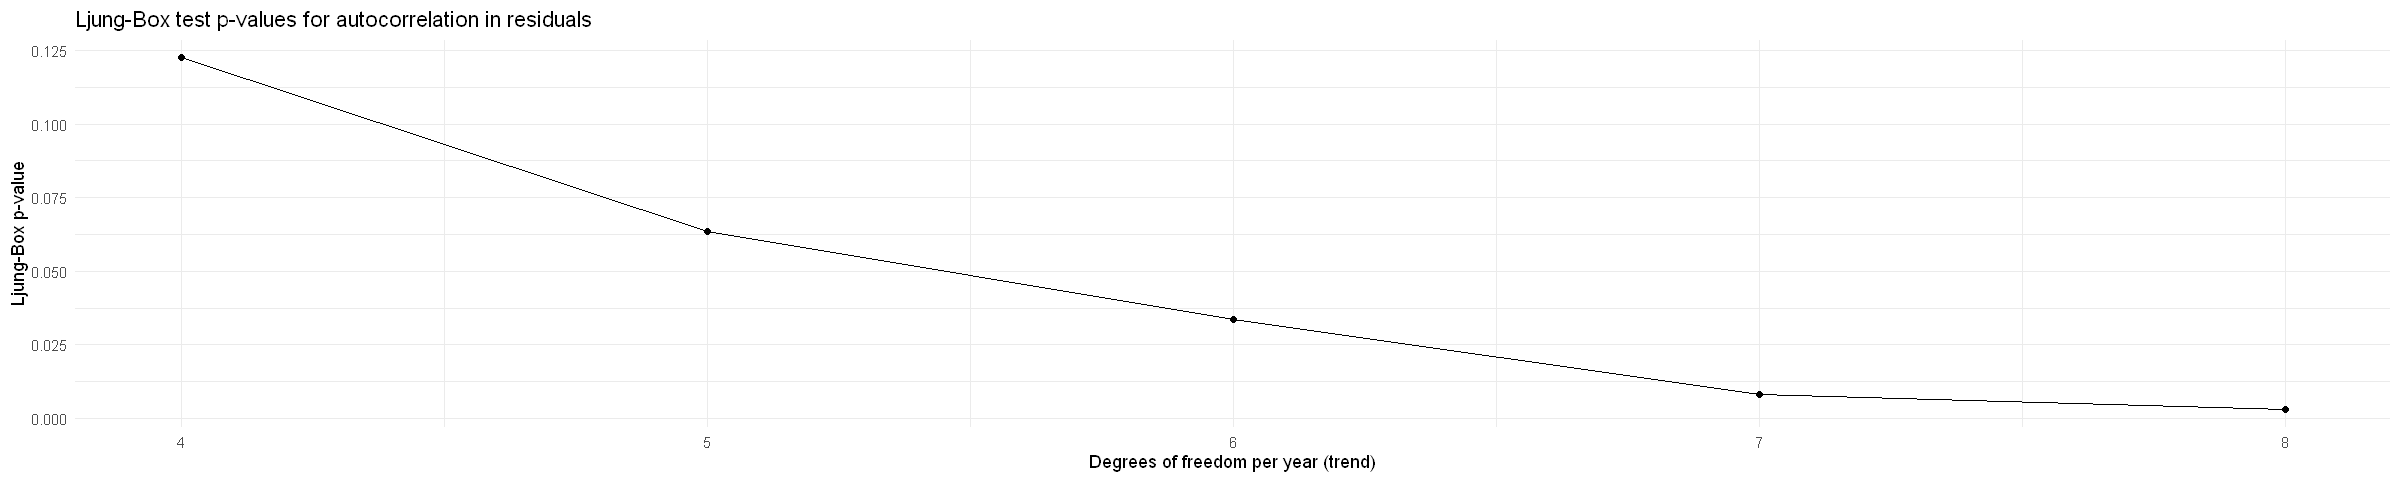

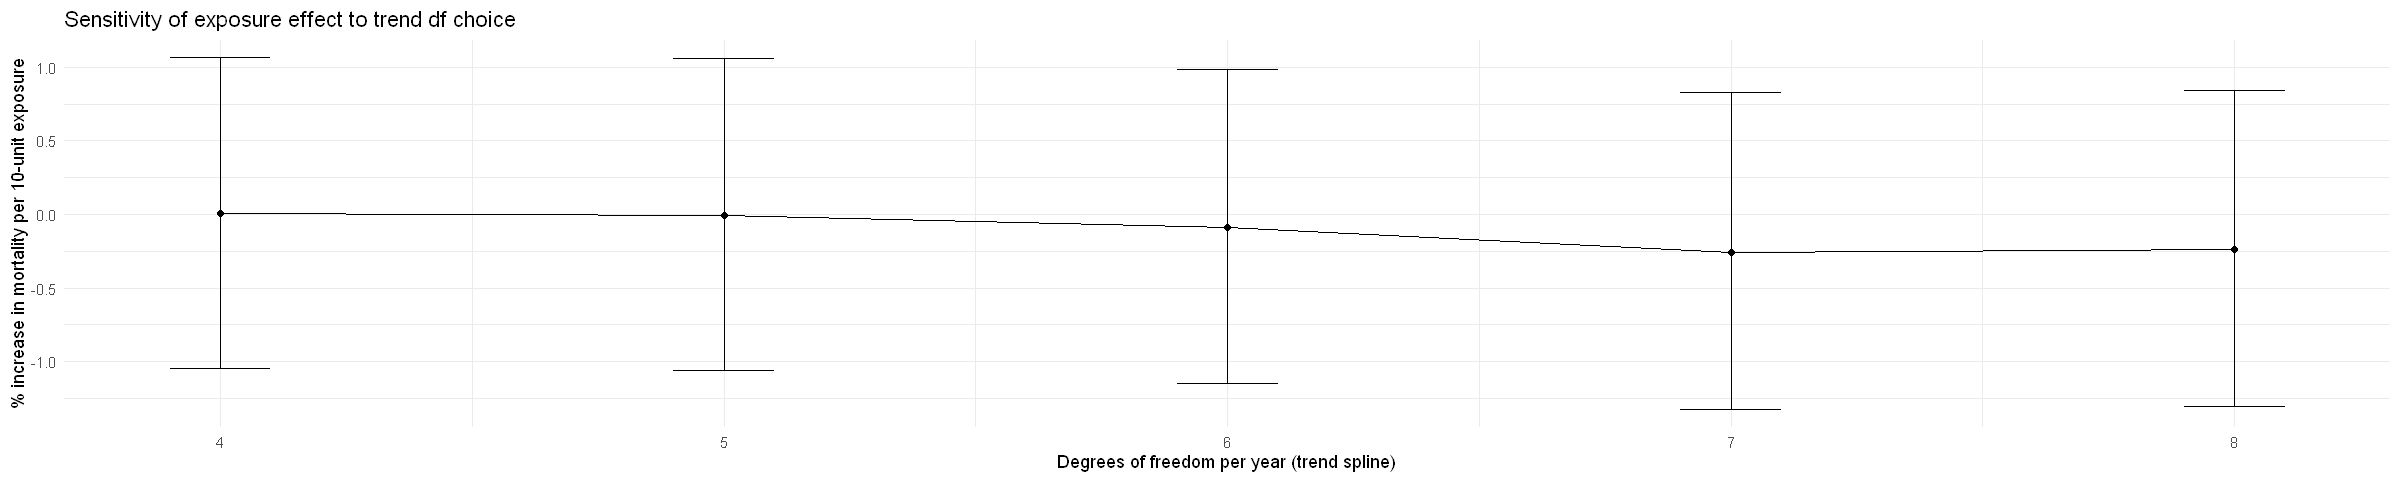

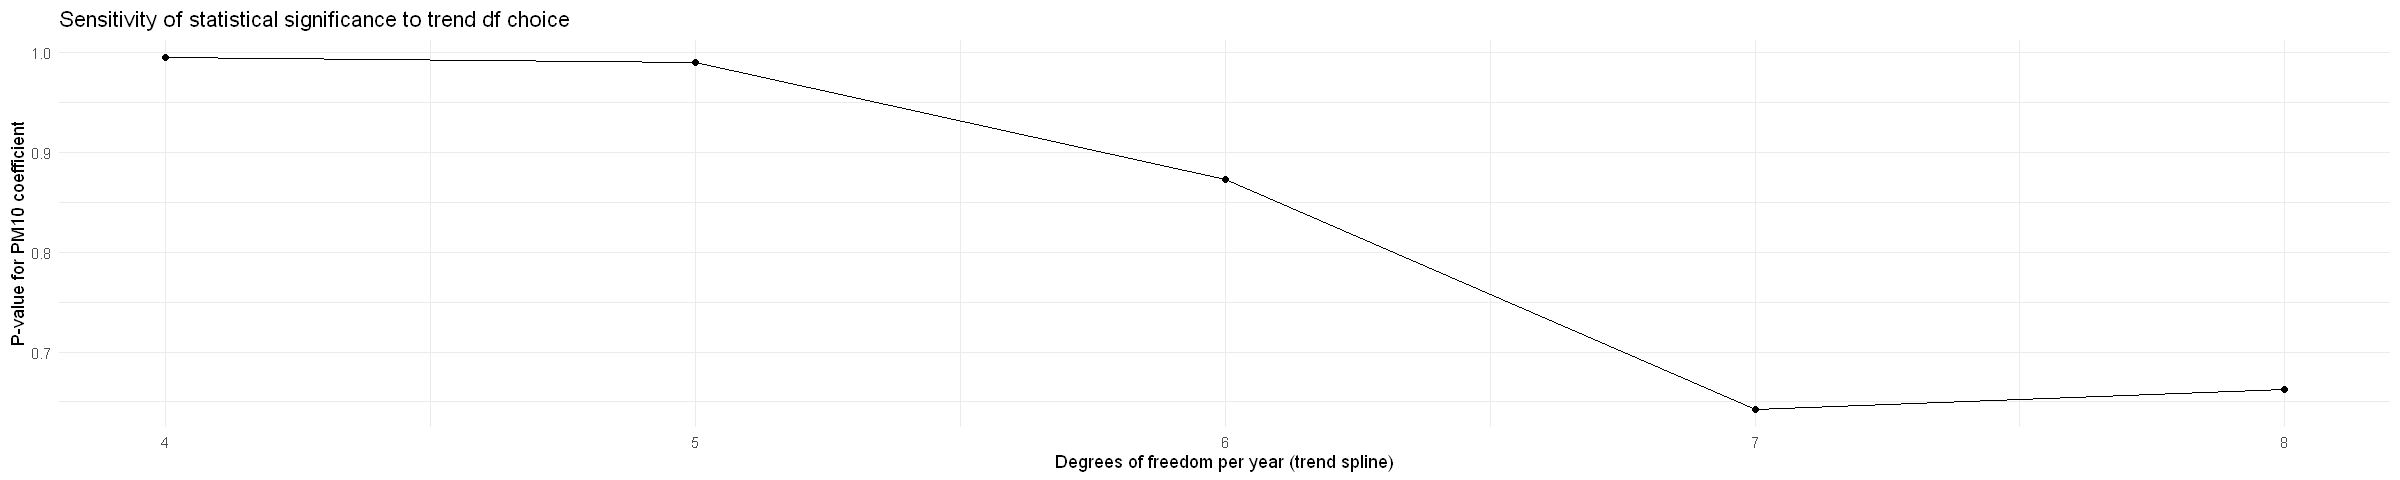

In [7]:
ggplot(results, aes(x = df_trend, y = qaic)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend)",
       y = "QAIC",
       title = "Sensitivity of model fit to trend df") +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = lb_pvalue)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend)",
       y = "Ljung-Box p-value",
       title = "Ljung-Box test p-values for autocorrelation in residuals"
       ) +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = perc_increase)) +
  geom_point() +
  geom_errorbar(aes(ymin = lowerCI, ymax = upperCI), width = 0.2) +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend spline)",
       y = "% increase in mortality per 10-unit exposure",
       title = "Sensitivity of exposure effect to trend df choice") +
  theme_minimal()

ggplot(results, aes(x = df_trend, y = Pr_val)) +
  geom_point() +
  geom_line() +
  labs(x = "Degrees of freedom per year (trend spline)",
       y = "P-value for PM10 coefficient",
       title = "Sensitivity of statistical significance to trend df choice") +
  theme_minimal()

We pick 4 degrees of freedom for trend spline term

Define the model using the specified degrees of freedom

In [8]:
model5 <- glm(y ~ ns(l01temphot, k=ktemphot.lag01) + ns(l16tempcold, k=ktempcold.lag16) + ns(trend, df=4*nyears) + as.factor(dow) + as.factor(Holiday.1), data=data, family=quasipoisson)

Now we analyze single lags

In [9]:
data <- arrange(data, date) %>% mutate( PM10_l1=lag(PM10,1), PM10_l2=lag(PM10,2), PM10_l3=lag(PM10,3),
                                        PM10_l4=lag(PM10,4), PM10_l5=lag(PM10,5), PM10_l6=lag(PM10,6), PM10_l7=lag(PM10,7))

In [10]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])

res1       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6)   
res1[, RR    := exp(beta*10)]
res1[, inf   := exp((beta-1.96*se)*10)]
res1[, sup   := exp((beta+1.96*se)*10)]
res1[, IR10  := (RR-1)*100]
res1[, inf10 := (inf-1)*100]
res1[, sup10 := (sup-1)*100]
res1[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res1

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,3.340515e-06,0.0005378820,0.995045489,1.0000334,0.9895459,1.0106320,0.00334057,-1.0454055,1.0632015,
1,5.775978e-05,0.0005414901,0.915064596,1.0005778,0.9900146,1.0112537,0.05777646,-0.9985419,1.1253654,
2,-3.047819e-04,0.0005433178,0.574894699,0.9969568,0.9863965,1.0076302,-0.30431788,-1.3603472,0.7630172,
3,9.068358e-04,0.0005337655,0.089510601,1.0091096,0.9986075,1.0197221,0.91096000,-0.1392475,1.9722122,
4,7.546225e-04,0.0005356717,0.159091972,1.0075748,0.9970514,1.0182092,0.75747694,-0.2948584,1.8209192,
5,3.222038e-04,0.0005387065,0.549847421,1.0032272,0.9926902,1.0138761,0.32272342,-0.7309763,1.3876078,
6,-1.434767e-03,0.0005482413,0.008947128,0.9857548,0.9752190,0.9964043,-1.42452307,-2.4780980,-0.3595658,**


Average Lags

In [11]:
# Build the average lags
data <- arrange(data, date) %>% mutate( PM10_l01=(PM10    + PM10_l1)/2,
                                        PM10_l25=(PM10_l2 + PM10_l3 + PM10_l4 + PM10_l5)/4,
                                        PM10_l05=(PM10    + PM10_l1 + PM10_l2 + PM10_l3 + PM10_l4 + PM10_l5)/6)

In [12]:
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res       <- rbind(cp_mod5_01, cp_mod5_25, cp_mod5_05)   
res[, RR    := exp(beta*10)]
res[, inf   := exp((beta-1.96*se)*10)]
res[, sup   := exp((beta+1.96*se)*10)]
res[, IR10  := (RR-1)*100]
res[, inf10 := (inf-1)*100]
res[, sup10 := (sup-1)*100]
res[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
01,0.0002300528,0.0006462908,0.7219154,1.002303,0.9896868,1.015080,0.2303177,-1.031322,1.508041,
25,0.0006632360,0.0008539687,0.4374736,1.006654,0.9899455,1.023645,0.6654403,-1.005454,2.364537,
05,0.0009407028,0.0010345891,0.3633491,1.009451,0.9891880,1.030130,0.9451413,-1.081204,3.012997,


Now check for NO2

In [13]:
data <- arrange(data, date) %>% mutate( NO2_l1=lag(NO2,1), NO2_l2=lag(NO2,2), NO2_l3=lag(NO2,3),
                                        NO2_l4=lag(NO2,4), NO2_l5=lag(NO2,5), NO2_l6=lag(NO2,6), NO2_l7=lag(NO2,7))

data <- arrange(data, date) %>% mutate( NO2_l01=(NO2    + NO2_l1)/2,
                                        NO2_l25=(NO2_l2 + NO2_l3 + NO2_l4 + NO2_l5)/4,
                                        NO2_l05=(NO2    + NO2_l1 + NO2_l2 + NO2_l3 + NO2_l4 + NO2_l5)/6)

In [14]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0031278347,0.002165716,0.1488495,1.0317727,0.9888925,1.076512,3.1772655,-1.110753,7.651220,
1,0.0024352010,0.002222274,0.2733121,1.0246509,0.9809787,1.070267,2.4650942,-1.902132,7.026745,
2,-0.0006073202,0.002226890,0.7851000,0.9939452,0.9514956,1.038289,-0.6054797,-4.850443,3.828866,
3,0.0018816477,0.002223718,0.3975738,1.0189946,0.9755358,1.064389,1.8994623,-2.446418,6.438946,
4,0.0013384578,0.002233972,0.5491591,1.0134746,0.9700562,1.058836,1.3474552,-2.994380,5.883625,
5,0.0005018777,0.002277062,0.8255811,1.0050314,0.9611627,1.050902,0.5031392,-3.883735,5.090236,
6,-0.0031583128,0.002323625,0.1742544,0.9689104,0.9257730,1.014058,-3.1089590,-7.422696,1.405781,
01,0.0031844787,0.002474976,0.1983823,1.0323573,0.9834733,1.083671,3.2357258,-1.652666,8.367097,
25,0.0021621003,0.003071353,0.4815560,1.0218564,0.9621571,1.085260,2.1856431,-3.784287,8.525992,


Now SO2

In [15]:
data <- arrange(data, date) %>% mutate( SO2_l1=lag(SO2,1), SO2_l2=lag(SO2,2), SO2_l3=lag(SO2,3),
                                        SO2_l4=lag(SO2,4), SO2_l5=lag(SO2,5), SO2_l6=lag(SO2,6), SO2_l7=lag(SO2,7))

data <- arrange(data, date) %>% mutate( SO2_l01=(SO2    + SO2_l1)/2,
                                        SO2_l25=(SO2_l2 + SO2_l3 + SO2_l4 + SO2_l5)/4,
                                        SO2_l05=(SO2    + SO2_l1 + SO2_l2 + SO2_l3 + SO2_l4 + SO2_l5)/6)

In [16]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-6.265080e-04,0.002615188,0.81069680,0.9937545,0.9441004,1.046020,-0.624549495,-5.5899601,4.602012,
1,-4.547233e-06,0.002643048,0.99862749,0.9999545,0.9494720,1.053121,-0.004547129,-5.0527984,5.312115,
2,-2.411169e-03,0.002685154,0.36933489,0.9761767,0.9261300,1.028928,-2.382332441,-7.3870040,2.892784,
3,6.964120e-04,0.002648897,0.79265517,1.0069884,0.9560412,1.060651,0.698842623,-4.3958789,6.065061,
4,2.850015e-03,0.002662034,0.28449730,1.0289102,0.9766024,1.084020,2.891016018,-2.3397650,8.401963,
5,4.707558e-03,0.002662060,0.07717862,1.0482012,0.9949122,1.104345,4.820122810,-0.5087808,10.434451,
6,2.995437e-03,0.002680584,0.26395994,1.0304075,0.9776681,1.085992,3.040751360,-2.2331940,8.599195,
01,-2.556746e-04,0.002933816,0.93056499,0.9974465,0.9417085,1.056484,-0.255348018,-5.8291539,5.648362,
25,3.279225e-03,0.003429695,0.33915462,1.0333358,0.9661562,1.105187,3.333584601,-3.3843799,10.518669,


### Now gender based analysis

#### PM10

Male

In [17]:
data$y <- data$Total_Male..30

In [18]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-2.163299e-04,0.0007201452,0.7639100,0.9978390,0.9838536,1.012023,-0.21609609,-1.614637,1.2023253,
1,-3.397437e-05,0.0007240195,0.9625787,0.9996603,0.9855745,1.013947,-0.03396860,-1.442547,1.3947409,
2,-5.599499e-05,0.0007244933,0.9384030,0.9994402,0.9853484,1.013734,-0.05597931,-1.465162,1.3733569,
3,2.712606e-04,0.0007235775,0.7077898,1.0027163,0.9885960,1.017038,0.27162880,-1.140399,1.7038248,
4,-4.052073e-04,0.0007344855,0.5812331,0.9959561,0.9817211,1.010398,-0.40438749,-1.827887,1.0397525,
5,4.168942e-04,0.0007160803,0.5605153,1.0041776,0.9901823,1.018371,0.41776440,-0.981772,1.8370821,
6,-1.176945e-03,0.0007302570,0.1072131,0.9882995,0.9742547,1.002547,-1.17004578,-2.574527,0.2546828,
01,4.279036e-05,0.0008648590,0.9605452,1.0004280,0.9836124,1.017531,0.04279952,-1.638757,1.7531036,
25,-2.522122e-04,0.0011459799,0.8258322,0.9974811,0.9753262,1.020139,-0.25189439,-2.467383,2.0139195,


Female

In [19]:
data$y <- data$Total_Female..30

In [20]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0002742643,0.0007930980,0.729524728,1.0027464,0.9872795,1.0184556,0.2746407,-1.2720481,1.8455602,
1,0.0001740521,0.0007956250,0.826861698,1.0017420,0.9862418,1.0174859,0.1742037,-1.3758208,1.7485891,
2,-0.0006048301,0.0008043052,0.452159084,0.9939700,0.9784235,1.0097634,-0.6030047,-2.1576507,0.9763434,
3,0.0016768518,0.0007743517,0.030486673,1.0169099,1.0015925,1.0324616,1.6909899,0.1592492,3.2461555,*
4,0.0021230035,0.0007684955,0.005796097,1.0214570,1.0061866,1.0369592,2.1456995,0.6186580,3.6959161,**
5,0.0002055133,0.0007997227,0.797224324,1.0020572,0.9864729,1.0178878,0.2057246,-1.3527108,1.7887802,
6,-0.0017564164,0.0008162837,0.031557451,0.9825892,0.9669937,0.9984362,-1.7410813,-3.3006325,-0.1563779,*
01,0.0004622798,0.0009510431,0.626975092,1.0046335,0.9860801,1.0235359,0.4633500,-1.3919857,2.3535943,
25,0.0017850178,0.0012526555,0.154346483,1.0180104,0.9933205,1.0433140,1.8010445,-0.6679463,4.3314043,


#### NO2

Male

In [21]:
data$y <- data$Total_Male..30

In [22]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0064411419,0.002886253,0.02576477,1.0665311,1.0078717,1.128605,6.6531099,0.7871689,12.8604562,*
1,0.0003659782,0.002983225,0.90237574,1.0036665,0.9466637,1.064102,0.3666487,-5.3336346,6.4101715,
2,-0.0016393469,0.002996195,0.58435108,0.9837402,0.9276332,1.043241,-1.6259827,-7.2366807,4.3240729,
3,0.0020744427,0.002985850,0.48730021,1.0209611,0.9629265,1.082493,2.0961089,-3.7073531,8.2493397,
4,0.0004063291,0.003011499,0.89268617,1.0040716,0.9465210,1.065121,0.4071557,-5.3478965,6.5121275,
5,-0.0005608559,0.003059538,0.85457319,0.9944071,0.9365283,1.055863,-0.5592860,-6.3471673,5.5862947,
6,-0.0057744301,0.003136632,0.06579761,0.9438913,0.8876105,1.003741,-5.6108732,-11.2389527,0.3740665,
01,0.0038397862,0.003311534,0.24640568,1.0391446,0.9738401,1.108828,3.9144587,-2.6159946,10.8828362,
25,0.0008644373,0.004139019,0.83458978,1.0086818,0.9300840,1.093922,0.8681843,-6.9916017,9.3921710,


Female

In [23]:
data$y <- data$Total_Female..30

In [24]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-9.588889e-04,0.003208186,0.7650612,0.9904569,0.9300943,1.054737,-0.954306246,-6.990572,5.473711,
1,4.990456e-03,0.003256982,0.1256477,1.0511708,0.9861643,1.120462,5.117076581,-1.383569,12.046235,
2,6.401169e-04,0.003262478,0.8444722,1.0064217,0.9440809,1.072879,0.642169979,-5.591909,7.287906,
3,1.640097e-03,0.003267340,0.6157545,1.0165362,0.9534780,1.083765,1.653620250,-4.652196,8.376471,
4,2.473058e-03,0.003276853,0.4505284,1.0250389,0.9612741,1.093034,2.503891980,-3.872595,9.303354,
5,1.802018e-03,0.003331875,0.5886860,1.0181835,0.9538159,1.086895,1.818352538,-4.618407,8.689492,
6,2.445461e-06,0.003388532,0.9994243,1.0000245,0.9357651,1.068697,0.002445491,-6.423489,6.869651,
01,2.406512e-03,0.003650570,0.5098458,1.0243570,0.9536238,1.100337,2.435701881,-4.637623,10.033677,
25,3.710618e-03,0.004489993,0.4086822,1.0378032,0.9503759,1.133273,3.780321320,-4.962409,13.327316,


#### SO2

Male

In [25]:
data$y <- data$Total_Male..30

In [26]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0005597810,0.003492450,0.8726774,1.0056135,0.9390804,1.076860,0.5613507,-6.091963,7.686047,
1,-0.0019758535,0.003552419,0.5781492,0.9804354,0.9144926,1.051133,-1.9564614,-8.550744,5.113326,
2,-0.0021431925,0.003605022,0.5522571,0.9787961,0.9120227,1.050458,-2.1203893,-8.797726,5.045826,
3,0.0004523532,0.003600103,0.9000241,1.0045338,0.9360948,1.077976,0.4533779,-6.390516,7.797636,
4,0.0025763927,0.003599688,0.4742604,1.0260987,0.9561983,1.101109,2.6098686,-4.380171,10.110896,
5,0.0054242006,0.003589754,0.1309720,1.0557401,0.9840120,1.132697,5.5740067,-1.598798,13.269662,
6,0.0044934697,0.003620115,0.2146877,1.0459596,0.9743160,1.122871,4.5959554,-2.568397,12.287117,
01,-0.0013950889,0.003928568,0.7225501,0.9861460,0.9130626,1.065079,-1.3854026,-8.693739,6.507907,
25,0.0042695150,0.004666376,0.3603564,1.0436197,0.9524041,1.143571,4.3619699,-4.759586,14.357134,


Female

In [27]:
data$y <- data$Total_Female..30

In [28]:
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-0.002058841,0.003879219,0.5956724,0.9796221,0.9078999,1.057010,-2.037792,-9.210006,5.701012,
1,0.002475472,0.003883290,0.5239078,1.0250637,0.9499388,1.106130,2.506366,-5.006125,10.612975,
2,-0.002678838,0.003931492,0.4957260,0.9735672,0.9013644,1.051554,-2.643275,-9.863556,5.155378,
3,0.001025929,0.003880274,0.7915074,1.0103121,0.9363237,1.090147,1.031210,-6.367634,9.014711,
4,0.003226089,0.003885767,0.4065263,1.0327869,0.9570495,1.114518,3.278692,-4.295048,11.451789,
5,0.003891145,0.003892776,0.3176582,1.0396784,0.9633033,1.122109,3.967842,-3.669669,12.210890,
6,0.001194148,0.003934721,0.7615544,1.0120131,0.9368997,1.093148,1.201307,-6.310030,9.314845,
01,0.001216062,0.004335524,0.7791388,1.0122349,0.9297722,1.102011,1.223486,-7.022778,10.201121,
25,0.002202118,0.004978670,0.6583253,1.0222654,0.9272234,1.127049,2.226544,-7.277660,12.704945,


### Analize by age 

#### Old

In [29]:
data$y <- data$X.65

PM10

In [30]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-0.0005299671,0.0006803432,0.43610392,0.9947143,0.9815381,1.008067,-0.5285653,-1.84618502,0.80674224,
1,-0.0006629574,0.0006899367,0.33673906,0.9933924,0.9800494,1.006917,-0.6607647,-1.99506327,0.69169981,
2,-0.0008160869,0.0006867433,0.23486160,0.9918723,0.9786110,1.005313,-0.8127660,-2.13889794,0.53133659,
3,0.0010616863,0.0006698228,0.11314369,1.0106734,0.9974915,1.024030,1.0673422,-0.25085118,2.40295558,
4,0.0012692402,0.0006652811,0.05657957,1.0127733,0.9996530,1.026066,1.2773293,-0.03470469,2.60658357,
5,0.0009281449,0.0006698175,0.16602712,1.0093247,0.9961604,1.022663,0.9324655,-0.38395841,2.26628597,
6,-0.0013149915,0.0006880043,0.05612975,0.9869362,0.9737168,1.000335,-1.3063833,-2.62832220,0.03350252,
01,-0.0006551295,0.0008198110,0.42433025,0.9934701,0.9776343,1.009562,-0.6529882,-2.23656865,0.95624319,
25,0.0010220601,0.0010718064,0.34042998,1.0102730,0.9892712,1.031721,1.0273010,-1.07288342,3.17207155,


#### Young

In [31]:
data$y <- data$Total..30 - data$X.65

In [32]:
mod5_0    <- update(model5, . ~ PM10 + .)
mod5_1    <- update(model5, . ~ PM10_l1 + .)
mod5_2    <- update(model5, . ~ PM10_l2 + .)
mod5_3    <- update(model5, . ~ PM10_l3 + .)
mod5_4    <- update(model5, . ~ PM10_l4 + .)
mod5_5    <- update(model5, . ~ PM10_l5 + .)
mod5_6    <- update(model5, . ~ PM10_l6 + .)
mod5_01    <- update(model5, . ~ PM10_l01 + .)
mod5_25    <- update(model5, . ~ PM10_l25 + .)
mod5_05    <- update(model5, . ~ PM10_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res4       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res4[, RR    := exp(beta*10)]
res4[, inf   := exp((beta-1.96*se)*10)]
res4[, sup   := exp((beta+1.96*se)*10)]
res4[, IR10  := (RR-1)*100]
res4[, inf10 := (inf-1)*100]
res4[, sup10 := (sup-1)*100]
res4[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res4

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,9.735866e-04,0.0008841651,0.27099062,1.0097834,0.9924350,1.027435,0.97834137,-0.7565010,2.7435099,
1,1.398343e-03,0.0008792033,0.11191289,1.0140817,0.9967563,1.031708,1.40816559,-0.3243681,3.1708137,
2,6.706915e-04,0.0008920371,0.45223476,1.0067295,0.9892809,1.024486,0.67294565,-1.0719149,2.4485814,
3,6.389298e-04,0.0008918056,0.47381348,1.0064098,0.9889712,1.024156,0.64097528,-1.1028824,2.4155825,
4,-2.464498e-04,0.0009144592,0.78757460,0.9975385,0.9798185,1.015579,-0.24614637,-2.0181471,1.5579010,
5,-8.352634e-04,0.0009203928,0.36426512,0.9916822,0.9739529,1.009734,-0.83178473,-2.6047100,0.9734138,
6,-1.632452e-03,0.0009150983,0.07461404,0.9838080,0.9663198,1.001613,-1.61919942,-3.3680199,0.1612708,
01,1.859928e-03,0.0010582860,0.07901297,1.0187733,0.9978592,1.040126,1.87733262,-0.2140829,4.0125822,
25,3.089291e-05,0.0014213269,0.98266172,1.0003090,0.9728269,1.028567,0.03089768,-2.7173064,2.8567376,


NO2

Old

In [33]:
data$y <- data$X.65

In [34]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0003292324,0.002724149,0.9038183,1.0032977,0.9511334,1.058323,0.3297749,-4.886664,5.832306,
1,0.0005840334,0.002788342,0.8341173,1.0058574,0.9523610,1.062359,0.5857422,-4.763905,6.235892,
2,-0.0018970396,0.002792382,0.4969991,0.9812084,0.9289493,1.036407,-1.8791591,-7.105067,3.640739,
3,0.0004498575,0.002799994,0.8723770,1.0045087,0.9508668,1.061177,0.4508709,-4.913322,6.117678,
4,0.0001325047,0.002809125,0.9623837,1.0013259,0.9476843,1.058004,0.1325926,-5.231566,5.800378,
5,0.0012883463,0.002859913,0.6524176,1.0129668,0.9577478,1.071370,1.2966812,-4.225225,7.136953,
6,-0.0033928753,0.002918418,0.2451627,0.9666404,0.9128993,1.023545,-3.3359628,-8.710074,2.354514,
01,0.0001986744,0.003109762,0.9490674,1.0019887,0.9427401,1.064961,0.1988719,-5.725986,6.496090,
25,0.0009717851,0.003862043,0.8013617,1.0097652,0.9361513,1.089168,0.9765223,-6.384872,8.916778,


Young

In [35]:
data$y <- data$Total..30 - data$X.65

In [36]:
mod5_0    <- update(model5, . ~ NO2 + .)
mod5_1    <- update(model5, . ~ NO2_l1 + .)
mod5_2    <- update(model5, . ~ NO2_l2 + .)
mod5_3    <- update(model5, . ~ NO2_l3 + .)
mod5_4    <- update(model5, . ~ NO2_l4 + .)
mod5_5    <- update(model5, . ~ NO2_l5 + .)
mod5_6    <- update(model5, . ~ NO2_l6 + .)

mod5_01    <- update(model5, . ~ NO2_l01 + .)
mod5_25    <- update(model5, . ~ NO2_l25 + .)
mod5_05    <- update(model5, . ~ NO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res2       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res2[, RR    := exp(beta*10)]
res2[, inf   := exp((beta-1.96*se)*10)]
res2[, sup   := exp((beta+1.96*se)*10)]
res2[, IR10  := (RR-1)*100]
res2[, inf10 := (inf-1)*100]
res2[, sup10 := (sup-1)*100]
res2[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res2

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.008460773,0.003618571,0.01949261,1.0882901,1.0137778,1.168279,8.8290076,1.3777777,16.827900,*
1,0.005960500,0.003714214,0.10872437,1.0614172,0.9868931,1.141569,6.1417207,-1.3106931,14.156895,
2,0.001847374,0.003725961,0.62009046,1.0186454,0.9469063,1.095820,1.8645433,-5.3093666,9.581960,
3,0.004670899,0.003699650,0.20693004,1.0478170,0.9745259,1.126620,4.7817036,-2.5474065,12.662013,
4,0.003649645,0.003733257,0.32840693,1.0371706,0.9639890,1.115908,3.7170624,-3.6010983,11.590784,
5,-0.000942507,0.003796480,0.80396414,0.9906192,0.9195820,1.067144,-0.9380793,-8.0418022,6.714402,
6,-0.002636817,0.003859581,0.49457976,0.9739764,0.9030151,1.050514,-2.6023567,-9.6984853,5.051404,
01,0.008856594,0.004143162,0.03268652,1.0926063,1.0073871,1.185035,9.2606292,0.7387102,18.503454,*
25,0.004428370,0.005111415,0.38641049,1.0452789,0.9456336,1.155424,4.5278854,-5.4366350,15.542407,


SO2

Old

In [37]:
data$y <- data$X.65
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,0.0009244515,0.003227406,0.77457832,1.0092874,0.9474201,1.075195,0.9287378,-5.2579879,7.519461,
1,0.0005810771,0.003274247,0.85916162,1.0058277,0.9433061,1.072493,0.5827686,-5.6693916,7.249317,
2,-0.0016676705,0.003324362,0.61597904,0.9834616,0.9214247,1.049675,-1.6538419,-7.8575283,4.967521,
3,0.0011419972,0.003279842,0.72774399,1.0114854,0.9485081,1.078644,1.1485429,-5.1491891,7.864420,
4,0.0029126154,0.003289058,0.37598938,1.0295545,0.9652778,1.098111,2.9554469,-3.4722245,9.811129,
5,0.0072778435,0.003290646,0.02712417,1.0754922,1.0083162,1.147144,7.5492219,0.8316162,14.714368,*
6,0.0050345494,0.003300914,0.12739915,1.0516344,0.9857501,1.121922,5.1634367,-1.4249916,12.192214,
01,0.0012668950,0.003630254,0.72714743,1.0127495,0.9431933,1.087435,1.2749541,-5.6806694,8.743523,
25,0.0046897217,0.004227179,0.26741805,1.0480143,0.9646832,1.138544,4.8014286,-3.5316776,13.854363,


Young

In [38]:
data$y <- data$Total..30 - data$X.65
mod5_0    <- update(model5, . ~ SO2 + .)
mod5_1    <- update(model5, . ~ SO2_l1 + .)
mod5_2    <- update(model5, . ~ SO2_l2 + .)
mod5_3    <- update(model5, . ~ SO2_l3 + .)
mod5_4    <- update(model5, . ~ SO2_l4 + .)
mod5_5    <- update(model5, . ~ SO2_l5 + .)
mod5_6    <- update(model5, . ~ SO2_l6 + .)

mod5_01    <- update(model5, . ~ SO2_l01 + .)
mod5_25    <- update(model5, . ~ SO2_l25 + .)
mod5_05    <- update(model5, . ~ SO2_l05 + .)

cp_mod5_0 <- data.table(Lag="0", beta=mod5_0$coefficients[2], se=sqrt(summary(mod5_0)$cov.scaled[2,2]), P_val = summary(mod5_0)$coefficients[2, "Pr(>|t|)"])
cp_mod5_1 <- data.table(Lag="1", beta=mod5_1$coefficients[2], se=sqrt(summary(mod5_1)$cov.scaled[2,2]), P_val = summary(mod5_1)$coefficients[2, "Pr(>|t|)"])
cp_mod5_2 <- data.table(Lag="2", beta=mod5_2$coefficients[2], se=sqrt(summary(mod5_2)$cov.scaled[2,2]), P_val = summary(mod5_2)$coefficients[2, "Pr(>|t|)"])
cp_mod5_3 <- data.table(Lag="3", beta=mod5_3$coefficients[2], se=sqrt(summary(mod5_3)$cov.scaled[2,2]), P_val = summary(mod5_3)$coefficients[2, "Pr(>|t|)"])
cp_mod5_4 <- data.table(Lag="4", beta=mod5_4$coefficients[2], se=sqrt(summary(mod5_4)$cov.scaled[2,2]), P_val = summary(mod5_4)$coefficients[2, "Pr(>|t|)"])
cp_mod5_5 <- data.table(Lag="5", beta=mod5_5$coefficients[2], se=sqrt(summary(mod5_5)$cov.scaled[2,2]), P_val = summary(mod5_5)$coefficients[2, "Pr(>|t|)"])
cp_mod5_6 <- data.table(Lag="6", beta=mod5_6$coefficients[2], se=sqrt(summary(mod5_6)$cov.scaled[2,2]), P_val = summary(mod5_6)$coefficients[2, "Pr(>|t|)"])
cp_mod5_01 <- data.table(Lag="01", beta=mod5_01$coefficients[2], se=sqrt(summary(mod5_01)$cov.scaled[2,2]), P_val = summary(mod5_01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_25 <- data.table(Lag="25", beta=mod5_25$coefficients[2], se=sqrt(summary(mod5_25)$cov.scaled[2,2]), P_val = summary(mod5_25)$coefficients[2, "Pr(>|t|)"])
cp_mod5_05 <- data.table(Lag="05", beta=mod5_05$coefficients[2], se=sqrt(summary(mod5_05)$cov.scaled[2,2]), P_val = summary(mod5_05)$coefficients[2, "Pr(>|t|)"])

res3       <- rbind(cp_mod5_0, cp_mod5_1, cp_mod5_2, cp_mod5_3, cp_mod5_4, cp_mod5_5, cp_mod5_6, cp_mod5_01, cp_mod5_25, cp_mod5_05) 
res3[, RR    := exp(beta*10)]
res3[, inf   := exp((beta-1.96*se)*10)]
res3[, sup   := exp((beta+1.96*se)*10)]
res3[, IR10  := (RR-1)*100]
res3[, inf10 := (inf-1)*100]
res3[, sup10 := (sup-1)*100]
res3[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res3

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-0.0038551714,0.004560325,0.3980244,0.9621819,0.8799114,1.052145,-3.7818055,-12.008862,5.214471,
1,-0.0011469248,0.004553244,0.8011558,0.9885963,0.9041927,1.080879,-1.1403726,-9.580734,8.087871,
2,-0.0038564938,0.004611231,0.4030911,0.9621692,0.8790223,1.053181,-3.7830778,-12.097774,5.318108,
3,-0.0001534876,0.004568224,0.9732010,0.9984663,0.9129519,1.091991,-0.1533698,-8.704808,9.199065,
4,0.0027489232,0.004572431,0.5477917,1.0278705,0.9397603,1.124242,2.7870547,-6.023968,12.424182,
5,-0.0003739198,0.004614266,0.9354234,0.9962678,0.9101200,1.090570,-0.3732216,-8.987999,9.056991,
6,-0.0011630842,0.004654061,0.8026897,0.9884365,0.9022619,1.082842,-1.1563466,-9.773810,8.284166,
01,-0.0033416875,0.005086270,0.5112724,0.9671353,0.8753707,1.068519,-3.2864699,-12.462925,6.851947,
25,0.0004992240,0.005948471,0.9331269,1.0050047,0.8944039,1.129282,0.5004722,-10.559608,12.928227,


### Multi-pollutant models

#### PM10

In [48]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ PM10_l01 + .)
mod5_no2_l01 <- update(model5, . ~ PM10_l01 + NO2_l01 + .)
mod5_so2_l01 <- update(model5, . ~ PM10_l05 + SO2_l05 + .)
mod5_no2_so2_l01 <- update(model5, . ~ PM10_l01 + NO2_l01 + SO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single PM10", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_l01 <- data.table(Lag="NO2", beta=mod5_no2_l01$coefficients[2], se=sqrt(summary(mod5_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_so2_l01 <- data.table(Lag="SO2", beta=mod5_so2_l01$coefficients[2], se=sqrt(summary(mod5_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_so2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_so2_l01 <- data.table(Lag="NO2+SO2", beta=mod5_no2_so2_l01$coefficients[2], se=sqrt(summary(mod5_no2_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_so2_l01)$coefficients[2, "Pr(>|t|)"])

res5       <- rbind(cp_mod5_single_l01, cp_mod5_no2_l01, cp_mod5_so2_l01, cp_mod5_no2_so2_l01)
res5[, RR    := exp(beta*10)]
res5[, inf   := exp((beta-1.96*se)*10)]
res5[, sup   := exp((beta+1.96*se)*10)]
res5[, IR10  := (RR-1)*100]
res5[, inf10 := (inf-1)*100]
res5[, sup10 := (sup-1)*100]
res5[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res5

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single PM10,2.300528e-04,0.0006462908,0.7219154,1.0023032,0.9896868,1.015080,0.230317655,-1.0313222,1.508041,
NO2,-8.016959e-06,0.0006781153,0.9905687,0.9999198,0.9867178,1.013299,-0.008016637,-1.3282232,1.329854,
SO2,1.185363e-03,0.0011110650,0.2862062,1.0119242,0.9901258,1.034202,1.192416220,-0.9874172,3.420240,
NO2+SO2,8.248825e-05,0.0007075888,0.9072102,1.0008252,0.9870408,1.014802,0.082522277,-1.2959155,1.480210,


#### NO2

In [49]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ NO2_l01 + .)
mod5_pm10_l01 <- update(model5, . ~ NO2_l01 + PM10_l01 + .)
mod5_so2_l01 <- update(model5, . ~ NO2_l01 + SO2_l01 + .)
mod5_pm10_so2_l01 <- update(model5, . ~ NO2_l01 + PM10_l01 + SO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single NO2", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_l01 <- data.table(Lag="PM10", beta=mod5_pm10_l01$coefficients[2], se=sqrt(summary(mod5_pm10_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_so2_l01 <- data.table(Lag="SO2", beta=mod5_so2_l01$coefficients[2], se=sqrt(summary(mod5_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_so2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_so2_l01 <- data.table(Lag="PM10+SO2", beta=mod5_pm10_so2_l01$coefficients[2], se=sqrt(summary(mod5_pm10_so2_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_so2_l01)$coefficients[2, "Pr(>|t|)"])

res6       <- rbind(cp_mod5_single_l01 ,cp_mod5_pm10_l01, cp_mod5_so2_l01, cp_mod5_pm10_so2_l01)
res6[, RR    := exp(beta*10)]
res6[, inf   := exp((beta-1.96*se)*10)]
res6[, sup   := exp((beta+1.96*se)*10)]
res6[, IR10  := (RR-1)*100]
res6[, inf10 := (inf-1)*100]
res6[, sup10 := (sup-1)*100]
res6[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res6

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single NO2,0.003184479,0.002474976,0.1983823,1.032357,0.9834733,1.083671,3.235726,-1.652666,8.367097,
PM10,0.003252749,0.002623442,0.2151916,1.033062,0.9812854,1.087571,3.306229,-1.871464,8.757120,
SO2,0.001286895,0.002864117,0.6532631,1.012952,0.9576549,1.071442,1.295211,-4.234505,7.144225,
PM10+SO2,0.001255254,0.002967880,0.6723909,1.012632,0.9554069,1.073284,1.263165,-4.459306,7.328387,


#### SO2

In [50]:
data$y <- data$Total..30
mod5_single_l01 <- update(model5, . ~ SO2_l01 + .)
mod5_pm10_l01 <- update(model5, . ~ SO2_l01 + PM10_l01 + .)
mod5_no2_l01 <- update(model5, . ~ SO2_l01 + NO2_l01 + .)
mod5_pm10_no2_l01 <- update(model5, . ~ SO2_l01 + PM10_l01 + NO2_l01 + .)

cp_mod5_single_l01 <- data.table(Lag="Single SO2", beta=mod5_single_l01$coefficients[2], se=sqrt(summary(mod5_single_l01)$cov.scaled[2,2]), P_val = summary(mod5_single_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_l01 <- data.table(Lag="PM10", beta=mod5_pm10_l01$coefficients[2], se=sqrt(summary(mod5_pm10_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_no2_l01 <- data.table(Lag="NO2", beta=mod5_no2_l01$coefficients[2], se=sqrt(summary(mod5_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_no2_l01)$coefficients[2, "Pr(>|t|)"])
cp_mod5_pm10_no2_l01 <- data.table(Lag="PM10+NO2", beta=mod5_pm10_no2_l01$coefficients[2], se=sqrt(summary(mod5_pm10_no2_l01)$cov.scaled[2,2]), P_val = summary(mod5_pm10_no2_l01)$coefficients[2, "Pr(>|t|)"])

res7       <- rbind(cp_mod5_single_l01, cp_mod5_pm10_l01, cp_mod5_no2_l01, cp_mod5_pm10_no2_l01)
res7[, RR    := exp(beta*10)]
res7[, inf   := exp((beta-1.96*se)*10)]
res7[, sup   := exp((beta+1.96*se)*10)]
res7[, IR10  := (RR-1)*100]
res7[, inf10 := (inf-1)*100]
res7[, sup10 := (sup-1)*100]
res7[, significance := ifelse(P_val < 0.001, "***", 
                      ifelse(P_val < 0.01, "**", 
                      ifelse(P_val < 0.05, "*", "")))]
res7

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single SO2,-0.0002556746,0.002933816,0.9305650,0.9974465,0.9417085,1.056484,-0.2553480,-5.829154,5.648362,
PM10,-0.0007891624,0.003068162,0.7970494,0.9921394,0.9342347,1.053633,-0.7860567,-6.576532,5.363317,
NO2,-0.0008326956,0.003202847,0.7949073,0.9917076,0.9313662,1.055958,-0.8292383,-6.863381,5.595845,
PM10+NO2,-0.0012681724,0.003270698,0.6982615,0.9873984,0.9260867,1.052769,-1.2601650,-7.391329,5.276913,


In [51]:
rbind(res5, res6, res7)

Lag,beta,se,P_val,RR,inf,sup,IR10,inf10,sup10,significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Single PM10,2.300528e-04,0.0006462908,0.7219154,1.0023032,0.9896868,1.015080,0.230317655,-1.0313222,1.508041,
NO2,-8.016959e-06,0.0006781153,0.9905687,0.9999198,0.9867178,1.013299,-0.008016637,-1.3282232,1.329854,
SO2,1.185363e-03,0.0011110650,0.2862062,1.0119242,0.9901258,1.034202,1.192416220,-0.9874172,3.420240,
NO2+SO2,8.248825e-05,0.0007075888,0.9072102,1.0008252,0.9870408,1.014802,0.082522277,-1.2959155,1.480210,
Single NO2,3.184479e-03,0.0024749763,0.1983823,1.0323573,0.9834733,1.083671,3.235725790,-1.6526659,8.367097,
PM10,3.252749e-03,0.0026234421,0.2151916,1.0330623,0.9812854,1.087571,3.306228985,-1.8714643,8.757120,
SO2,1.286895e-03,0.0028641170,0.6532631,1.0129521,0.9576549,1.071442,1.295210829,-4.2345053,7.144225,
PM10+SO2,1.255254e-03,0.0029678802,0.6723909,1.0126317,0.9554069,1.073284,1.263165228,-4.4593059,7.328387,
Single SO2,-2.556746e-04,0.0029338161,0.9305650,0.9974465,0.9417085,1.056484,-0.255348018,-5.8291539,5.648362,


In [ ]:
#write.csv(rbind(res5, res6, res7), file="./Tables and Figures/Multi pollutant models/Irbid.csv")